In [11]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import imodelsx.llm
from transformers import AutoModel, AutoTokenizer, pipeline
from tqdm import tqdm
from os.path import join
import config
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import analyze_helper
import qa_questions
fit_encoding = __import__('01_fit_encoding')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
results_dir = '/home/chansingh/mntv1/deep-fMRI/encoding/results_apr7'
r, cols_varied, mets = analyze_helper.load_clean_results(results_dir)

100%|██████████| 201/201 [00:43<00:00,  4.67it/s]

experiment varied these params: ['feature_space', 'distill_model_path', 'feature_selection_alpha_index', 'qa_embedding_model', 'qa_questions_version', 'pc_components', 'ndelays', 'seed']


# Check results

In [4]:
d = r
d = d[d.feature_selection_alpha_index >= 0]
d = d[d.distill_model_path == 'None']
cols_varied = [c for c in cols_varied if not c in [
    'distill_model_path']]
# d = d[(d.qa_questions_version == 'v1') *
#   (d.qa_embedding_model == 'mistral 7B')]
if len(cols_varied) > 0:
    d = d.groupby(cols_varied)[mets + ['weight_enet_mask_num_nonzero']].mean()
else:
    d = d[mets]

(
    d
    # .sort_values(by='corrs_test_mean', ascending=False)
    .sort_values(by='corrs_tune_pc_mean', ascending=False)
    .rename(columns=lambda x: x.replace('_', ' ').replace('corrs', ''))
    .style
    .background_gradient(cmap='magma', axis=0)
    .format(precision=3)
)
d = d.reset_index()

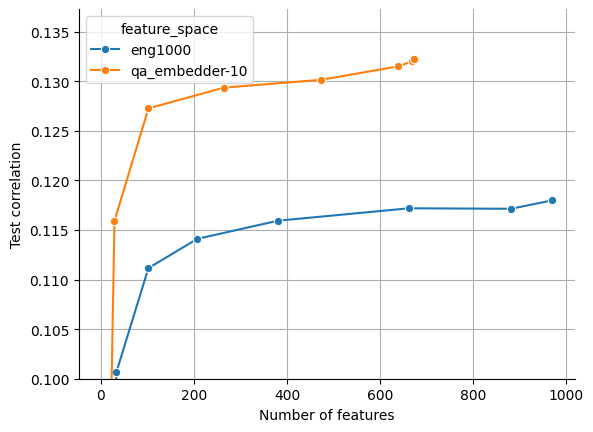

In [5]:
d = d[d.ndelays == 8]
d['(qa_questions_version, ndelays)'] = list(
    zip(d.qa_questions_version, d.ndelays))

sns.lineplot(data=d, x='weight_enet_mask_num_nonzero',
             y='corrs_test_mean',
             #  hue='(qa_questions_version, ndelays)',
             hue='feature_space',
             marker='o')
plt.xlabel('Number of features')
plt.ylabel('Test correlation')

# set ylim bottom to 0.1
plt.ylim(bottom=0.1)
plt.grid()
plt.show()

In [19]:
r.qa_embedding_model

0               
1      llama3-8B
2        mist-7B
3        mist-7B
4               
         ...    
196      mist-7B
197      mist-7B
198     mixt-moe
199    llama3-8B
200      mist-7B
Name: qa_embedding_model, Length: 201, dtype: object

# Check sparsity levels

In [6]:
sparse_feats_dir = join(config.repo_dir, 'sparse_feats')

In [7]:
!ls {sparse_feats_dir}

'v1_(0, -3, 15).joblib'  'v3_boostexamples_(0, -3, 15).joblib'


In [8]:
alphas_enet, coefs_enet = joblib.load(
    # join(sparse_feats_dir, 'v1_(0, -3, 15).joblib'))
    join(sparse_feats_dir, 'v3_boostexamples_(0, -3, 15).joblib'))

In [9]:
for i in range(len(alphas_enet)):
    coef_enet = coefs_enet[:, :, i]
    coef_nonzero = np.any(np.abs(coef_enet) > 0, axis=0)
    print(f'{i=} alpha={alphas_enet[i]:.2e}, n_nonzero={coef_nonzero.sum()}')

i=0 alpha=1.00e+00, n_nonzero=0
i=1 alpha=6.11e-01, n_nonzero=0
i=2 alpha=3.73e-01, n_nonzero=1
i=3 alpha=2.28e-01, n_nonzero=29
i=4 alpha=1.39e-01, n_nonzero=102
i=5 alpha=8.48e-02, n_nonzero=264
i=6 alpha=5.18e-02, n_nonzero=473
i=7 alpha=3.16e-02, n_nonzero=638
i=8 alpha=1.93e-02, n_nonzero=669
i=9 alpha=1.18e-02, n_nonzero=672
i=10 alpha=7.20e-03, n_nonzero=674
i=11 alpha=4.39e-03, n_nonzero=674
i=12 alpha=2.68e-03, n_nonzero=674
i=13 alpha=1.64e-03, n_nonzero=674
i=14 alpha=1.00e-03, n_nonzero=674


### Top questions

In [12]:
d = r[r.ndelays == 8]
row = d[(d.feature_selection_alpha_index == 3) *
        d.feature_space == 'qa_embedder-10'].iloc[0]

In [13]:
row[['weights_enet', 'weight_enet_mask', 'weight_enet_mask_num_nonzero']]

weights_enet                    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
weight_enet_mask                [False, False, False, False, False, False, Fal...
weight_enet_mask_num_nonzero                                                 29.0
Name: 126, dtype: object

In [14]:
model_params = joblib.load(
    join(row.save_dir_unique, 'model_params.pkl'))

In [15]:
model_params['weights'].shape

(232, 95556)

In [16]:
ndelays = row.ndelays
# weights = model_params['weights']
weights = model_params['weights_pc']
assert weights.shape[0] % ndelays == 0
emb_size = weights.shape[0] / ndelays
weights = weights.reshape(ndelays, int(emb_size), -1)

In [17]:
weights.shape

(8, 29, 100)

In [ ]:
for i in range(29):
    plt.plot(weights[:, i, 4])

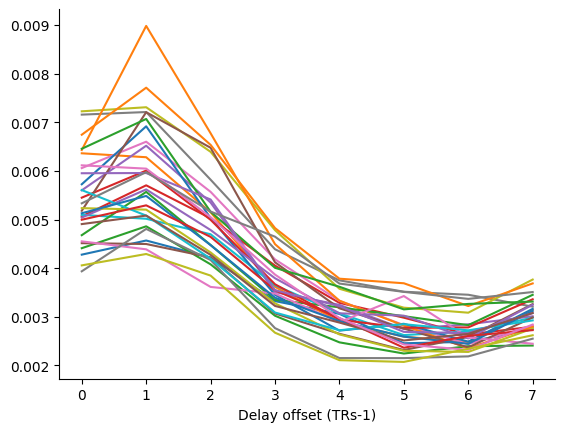

In [69]:
for i in range(29):
    plt.plot(np.abs(weights).mean(axis=-1)[:, i])
plt.xlabel('Delay offset (TRs-1)')
plt.show()

In [ ]:
qs = np.array(qa_questions.get_questions(row.qa_questions_version, full=True))

In [ ]:
mask = row.weight_enet_mask

In [ ]:
qs[mask]

In [18]:
r['weight_enet_mask']

0                                                    NaN
1                                                    NaN
2                                                    NaN
3      [True, False, False, False, False, False, True...
4      [False, False, False, True, False, False, Fals...
                             ...                        
196                                                  NaN
197                                                  NaN
198                                                  NaN
199                                                  NaN
200                                                  NaN
Name: weight_enet_mask, Length: 201, dtype: object